In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd

df = pd.read_csv('merged_data_for_team.csv')
df.sample(5)

,PERMNO,date_x,SIC_Industry_Code,TICKER_x,COMNAM_x,PERMCO,CUSIP_x,VOLUME,RETURN,SP_Rel_Return,...,Target1,Target2,future_returns,future_returns_sp_rel,future_returns_6_mos_only,future_returns_sp_rel_6_mos_only,Target_future_returns,Target_future_returns_sp_rel,Target_future_returns_6_mos_only,Target_future_returns_sp_rel_6_mos_only
4969,40125.0,2007-12-31,7373.0,CSC,COMPUTER SCIENCES CORP,20493.0,23355L10,226482.0,-0.063423,-0.008628,...,0,0,-0.004976,-0.021604,-0.004976,-0.021604,0,0,0,0
8106,61621.0,2012-03-30,8700.0,PAYX,PAYCHEX INC,6333.0,70432610,541112.0,-0.009904,0.031332,...,0,1,0.015789,0.004334,0.015789,0.004334,1,1,1,1
11449,76624.0,2014-03-31,3670.0,PMCS,P M C SIERRA INC,10901.0,69344F10,294443.0,0.036785,0.006932,...,1,1,0.000101,0.008892,0.000101,0.008892,1,1,1,1
16756,84342.0,2006-01-31,7310.0,MNST,MONSTER WORLDWIDE INC,15229.0,61174210,354873.0,0.041891,0.025467,...,1,1,-0.002873,-0.000340,-0.002873,-0.000340,0,0,0,0
21145,89525.0,2007-02-28,4841.0,CMCSA,COMCAST CORP NEW,43613.0,20030N10,2962205.0,-0.130101,-0.021846,...,0,0,0.002949,0.008148,0.002949,0.008148,1,1,1,1


# Classification column (Binary)

In [2]:
# Calculate the 10th percentile value
threshold = df['RETURN'].quantile(0.9)

# Create the new column and assign 1 to the top 10% values and 0 to the rest
df['Return_flg'] = df['RETURN'].apply(lambda x: 1 if x >= threshold else 0)

In [3]:
df.groupby('Return_flg').size()

Return_flg
0    21337
1     2368
dtype: int64

# Cleanning

In [28]:
from sklearn.impute import SimpleImputer

# Define the list of columns to filter
exclude_columns = ['Return_flg', 'RETURN', 'Month_Return', 'Target1', 'Target2', 'future_returns', 'future_returns_6_mos_only', 'Target_future_returns','SP_Rel_Return']

# Create an array of features excluding the specified columns
features = np.array([col for col in df.select_dtypes(include='number').columns if col not in exclude_columns])

# Impute missing values with median for numerical attributes
num_imputer = SimpleImputer(strategy='median')

df[features] = num_imputer.fit_transform(df[features])

# Training

In [29]:
#importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df['Return_flg'], test_size=0.20, random_state=42)

In [34]:
#create the classifier
classifier = DecisionTreeClassifier(max_depth=4, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# do our predictions on the test
predictions = classifier.predict(X_test)
# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.9002320185614849

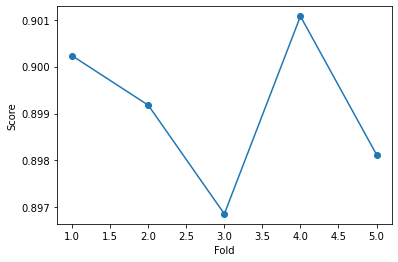

In [35]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

kf = KFold(n_splits=5,random_state=42,shuffle=True)

fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    feats = training[features] #defined above
    label = training['Return_flg']
    valid_feats = valid[features]
    valid_label = valid['Return_flg']
    classifier.fit(feats,label) #it is the last one we run, the best one
    pred = classifier.predict(valid_feats)
    score = accuracy_score(y_true = valid_label, y_pred = pred)
    fold.append(i+1)
    scr.append(score)
    
# Create a small DataFrame with the scores
performance = pd.DataFrame({'Score': scr, 'Fold': fold})

# Let's see what we have with matplotlib
plt.scatter(performance['Fold'], performance['Score'])
plt.plot(performance['Fold'], performance['Score'])
plt.xlabel('Fold')
plt.ylabel('Score')
plt.show()

In [36]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_feature_importance(classifier, features)

,feat,score
84,Past 12M Volatility,0.720224
86,Forward 12M Volatilty,0.126342
83,Past_12M_Return,0.055338
13,ps,0.030889
74,date_y,0.024741
...,...,...
30,pretret_earnat,0.000000
29,pretret_noa,0.000000
28,aftret_equity,0.000000
27,aftret_invcapx,0.000000


In [37]:
from sklearn import tree
import graphviz

# Visualize the decision tree
dot_data = tree.export_graphviz(classifier, out_file=None, 
                               feature_names=features,    
                               filled=True, rounded=True,  
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("iris_decision_tree")  # Save the visualization to a file
graph.view()  # Display the visualization in a new window

'iris_decision_tree.pdf'

In [10]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'